# Lab 5: The DFT and FFT
## Due Date: 4/3 @ 11:59pm on Canvas

In the last lab, we explored the Discrete-Time Fourier Transform (DTFT) and the frequency response of LSI systems. However, we know that it is impossible to hold an entire DTFT in computer memory since the DTFT of a signal has infinitely many points! We will discuss the Discrete Fourier Transform (DFT) and Fast Fourier Transform (FFT) in this lab as the practical implementations of the DTFT and consider some of the limitations and challenges when using the DFT.

# Discrete Fourier Transform

The Discrete Fourier Transform (DFT) is the discretized version of the DTFT. Sounds weird, right? Isn't the DTFT already discrete? It's in the name! But recall that the DTFT is a continuous function: it has infinitely many points to represent frequency content from $-\pi$ to $\pi$. The DFT is just a resampling of the DTFT. In other words, the DFT picks a finite number of equally spaced points in the DTFT for representation.

More concretely, the DFT is computed as follows: 

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi k}{N}n}, \quad 0\leq k\leq N-1.
$$
And the inverse DFT is given by:

$$
x[n] = \frac{1}{N}\sum_{k=0}^{N-1}X[k]e^{j\frac{2\pi k}{N}n}, \quad 0\leq n\leq N-1
$$
The DFT has $N$ "frequency bins" differentiated by our frequency index $k$. These are the samples we take from the DTFT. Perhaps a more intuitive formulation with respect to the DTFT makes these bins more obvious:

$$
\omega_k = \frac{2\pi k}{N},
$$

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j\omega_k n}, \quad 0\leq k\leq N-1.
$$

This representation explicitly shows that we try to capture $N$ equally spaced frequencies between 0 to $2\pi$ (same as $-\pi$ to $\pi$ by periodicity of DTFT) with the DFT.

### The Linear Algebra Intuition

The DFT gives an important insight into how we can use linear algebra or vectorize our systems to perform common signal processing operations. Consider our second formulation of the DFT. Suppose we fix $k$ to be one value $k_0$. The second formulation tells us that

$$
X[k_0] = \sum_{n=0}^{N-1}x[n]e^{-j\omega_{k_0} n}.
$$

There is helpful notation that can be introduced here using something call the "twiddle factor" (great name, right?). Different conventions exist for the twiddle factor, but we will opt for the one most consistent with your ECE 310 textbook. Consider the following notation for the twiddle factor $W$:

$$
W = e^{-j2\pi}
$$

$$
W_N = e^{-j\frac{2\pi}{N}}
$$

$$
W_N^{k} = e^{-j\frac{2\pi k}{N}}
$$

If we return to our expression for $X[k_0]$, we see that all we are doing at frequency $\omega_{k_0}$ is summing the product of each entry in the signal and some complex exponential. This is the same thing as taking an inner product (dot product) between the signal and the complex exponential rotating at frequency $w_{k_0}$! Thus,

$$
e^{-j\omega_{k_0}n} = [e^{-j\omega_{k_0}*(0)},e^{-j\omega_{k_0}*(1)},\ldots,e^{-j\omega_{k_0}*(N-1)}] = [W_N^{k_0*0},W_N^{k_0*1},W_N^{k_0*2},\ldots,W_N^{k_0*(N-1)}]
$$

$$
X[k_0] = \langle W_N^{-k_0n},x[n] \rangle = \sum_{n=0}^{N-1}x[n]e^{-j\omega_{k_0} n}.
$$

Note that when we take the inner product over complex numbers, we conjugate-transpose the first term by convention. For example, $\langle x,y\rangle = x^*y$, where $x^*$ is the transpose of $x$ and each element is complex conjugated. Thus,
$$
X[k_0] = \langle W_N^{-k_0n},x[n] \rangle = \sum_{i=0}^{N-1}W_N^{k_0i}x[i]
$$
as desired.

Now, recall that if the dot product between two vectors is large, they are similar. The same is true here! For each frequency, we take the dot product between our signal and a vector represented by a complex exponential rotating at a fixed frquency. The result tells us how much that fixed frequency is found in our signal. We can take one final step to make the entire DFT a matrix-vector product:

$$
X[k] = \mathbf{W}\vec{x}
$$

$$
X[k] = \underbrace{\begin{bmatrix}
W_N^0 & W_N^0 & \cdots & W_N^0 \\
W_N^0 & W_N^1 & \cdots & W_N^{N-1}\\
\vdots &  \vdots & \ddots & \vdots\\
W_N^0 & W_N^{N-1} & \cdots & W_N^{(N-1)(N-1)}
\end{bmatrix}}_{\mathbf{W}}
\underbrace{\begin{bmatrix}
x[0] \\
x[1] \\
\vdots \\
x[N-1] \\
\end{bmatrix}}_{\vec{x}} = 
\begin{bmatrix}
\langle W_N^{-0*n},\vec{x} \rangle\\
\langle W_N^{-1*n},\vec{x} \rangle\\
\vdots\\
\langle W_N^{-k*n},\vec{x} \rangle\\
\vdots\\
\langle W_N^{-(N-1)*n},\vec{x} \rangle\\
\end{bmatrix}
$$

In the above $\textbf{W}$ matrix, each row represents a frequency vector rotating at a certain frequency. More concretely, row $k$ in $\mathbf{W}$ represents the frequency vector rotating with frequency $\omega_k=\frac{2\pi}{N}k$. This kind of intuition is powerful in signal processing. If this confuses or (hopefully not) scares you, do not worry! It takes time to be comfortable with combining signal processing and linear algebra. Read the above explanation a couple times, ask your TA questions, check out your textbook's coverage of this, or hang out with some friends and chat about it!

### And finally the FFT!

We will not focus on the math of the FFT since you will cover it in ECE 310. For now, we should acknowledge the computational efficiency of the FFT. The previous two views of the DFT we have discussed - summation and vectorized versions - all require $\mathcal{O}(n^2)$ multiply-add operations. Conversely, the FFT is a divide-and-conquer algorithm that can perform the same computation in $\mathcal{O}(n\log n)$ multiply-add operations. Keep this in mind when completing Excercise 1.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
from skimage.io import imread
from scipy import signal
from scipy.io import wavfile
from linear_convolution import linear_convolution

%matplotlib inline

C:\Users\matt3\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Excercise 1: Implementing the DFT

There are multiple different implementations we can use to represent the DFT. In this exercise, you will compare three ways to compute the DFT. 

a. First, fill in the below function $\textrm{dfl_dft()}$ to create a double for-loop implementation of the DFT. Hint: this will work a lot like your DTFT function from Lab 4!

b. Next, fill in $\textrm{dft_matrix()}$ and $\textrm{vectorized_dft()}$ to create a vectorized implementation of the DFT.

c. Finally, let's test our double for-loop and vectorized methods against the $\textrm{np.fft.fft()}$ implementation. Run the provided code that benchmarks the running time of each method and verifies if your methods accurately compute the DFT of a randomly generated signal. Note that we do not benchmark the time to build the $\mathbf{W}$ matrix since this could be precomputed in a practical context. For example, if we compute 1000 length-500 DFTs, we would only need to construct $\mathbf{W}$ once. Comment on the results. Which method is fastest? Slowest? Why? Does anything surprise you?

In [16]:
# Function to complete for 1.a
def dfl_dft(x):
    N = len(x)
    dft = np.zeros(N, dtype=np.complex64)
    # for loop to iterate over 'k'
    for k in range(N):
        # for loop to iterate over 'n'
        for n in range(N):
            dft[k]+= x[n]*np.exp(-2j*np.pi*k/N*n)
    return dft

# Functions to complete for 1.b
# Construct the matrix W
def dft_matrix(N):
    W = np.zeros((N, N), dtype=np.complex64)
    # fill in W however you see fit!
    for n1 in range(N):
        for n2 in range(N):
            W[n1][n2] = np.exp(-2j*np.pi*n1/N*n2)
    return W

# Take the DFT of signal x using the matrix W
def vectorized_dft(W, x):
    # this should only take one line...
    # refer to the above math if you are unsure!
    dft = W @ x
    return dft      

In [17]:
# Provided code for 1.c
# Generate test signal
N = 500
x = np.random.uniform(size=N)

# Test double for-loop implementation
print('Double For Loop Time:')
%timeit dfl_dft(x)
print('')

# Test vectorized implementation
# don't time W matrix construction since this is precomputation that could be practically stored
W = dft_matrix(N)
print('Vectorized Time')
%timeit vectorized_dft(W, x)
print('')

# Test numpy's fft implementation
print('Numpy Time')
%timeit np.fft.fft(x)
print('')

# Test if results are equivalent
print('Double for-loop and numpy fft are equivalent:', np.allclose(dfl_dft(x), np.fft.fft(x)))
print('Vectorized DFT and numpy fft are equivalent:', np.allclose(vectorized_dft(W, x), np.fft.fft(x)))

Double For Loop Time:
853 ms ± 66.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Vectorized Time
3.29 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Numpy Time
18.5 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

Double for-loop and numpy fft are equivalent: True
Vectorized DFT and numpy fft are equivalent: True


## Comments here

Part 1(c):
Yes the two functions accuratly compute the DTF of the signals. The vectorized time is the fastest and the double for loop is the slowest. This does not suprise me because the double for loop uses two for loop which is $O(n^2)$ and the vectorized DTF function only calls the multiplication operation which runs in $O(nlogn)$ time. The difference in how fast they run did suprise me as I did not expect it to differ by such a large significant amount (in terms of milliseconds).


## Windowing and Zero-Padding

We will now briefly discuss the motivation for windowing and zero-padding. Exercises 2 and 3 will demonstrate and reinforce this theory.

Recall that the DFT works under the practical assumption that we only have a finite number of samples for our signal. Unlike the DTFT which uses infinitely points, we must use a finite collection to capture the frequency content of our signal. In the simplest case, we use a rectangular window that removes the $N$ points of our signal we would like to inspect for the DFT. Mathematically, we have,

$$
x_{\textrm{windowed}} = x[n](u[n-n_0]-u[n-(n_0+N)]),
$$

where $n_0$ is the start-point of our signal's window. This window signal is the same as a shifted rectangle function. We see that windowing is multiplying in the time domain, which by the convolution property must correspond to multiplication in the frequency domain. Thus, for a window function $w[n]$,

$$
x[n]w[n] \stackrel{\mathcal{F}}{\leftrightarrow} \frac{1}{2\pi}X(\omega) * W(\omega).
$$

Exercise 2 will explore the consequences of using the rectangular window and what other windows may be used. Next, let's explain the use of zero-padding. When zero-padding a signal, we are simply appending some number of zeros to the end of the original signal. What effect does this have? Suppose I have original signal $x[n]$ of length $N$ and a zero-padded signal $x_{zp}[n]$ of length $M>N$ that has been padded with $M-N$ zeros.

\begin{align*}
X[k] &= \sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi k}{N}n},\quad 0\leq k\leq N-1
\\X_{zp}[k] &= \sum_{n=0}^{M-1}x_{zp}[n]e^{-j\frac{2\pi k}{M}n},\quad 0\leq k\leq M-1
\\x_{zp}[n] = 0\textrm{ for all } n \geq N \implies X_{zp}[k] &= \sum_{n=0}^{N-1}x_{zp}[n]e^{-j\frac{2\pi k}{M}n}
\\X_{zp}[k] &= \sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi k}{M}n},\quad 0\leq n\leq M-1
\end{align*}
We see that the zero-padded signal's DFT will use the exact same signal values, and thus have the exact same frequency content. The difference is that the spacing of our frequency sampling is tighter!

$$
\frac{2\pi}{M} < \frac{2\pi}{N}
$$

Consequently, we add no "information" to our signal (only zeros) and gain higher frequency resolution at the cost of storing some zeros. This is what implictly happens when you use $\textrm{np.fft.fft()}$ or $\textrm{np.fft.rfft()}$ and specify a number of points greater than the length of the signal. Exercise 3 will give a brief example of how zero-padding can affect our ability to resolve different frequency components or notes in audio.

# Excercise 2: Windowing Effects

In this exercise, we want to investigate the effects of different windowing methods. When we are computing the DFT of a finite-length signal, it is assumed that there is periodic extension of this finite segment (more on this in Exercise 5 and related background). If the segment precisely captures full cycles of all the frequencies, then there will be no problem since we have no periodic interruptions and the transition between periodic copies of the signal will be seamless. However, if the segment does not capture full cycles of some frequencies, then there will be periodic interruptions or discontinuities as the signal is periodically extended. This can lead to changes in our ideal frequency content. This problem is referred to as spectral leakage. This is illustrated in the example below:

Suppose we are sampling a single sine wave, consider the two cases we have discussed:
1. We sample a window of the signal that perfectly captures an integer number of signal periods.
2. We sample a window of the signal that captures a fractional number of signal periods.

Below, our ideal signal is $\sin\left(\frac{\pi}{4}n\right)$. Thus, we need eight points to capture a full period of the signal.

Text(0.5, 0, '$\\omega$')

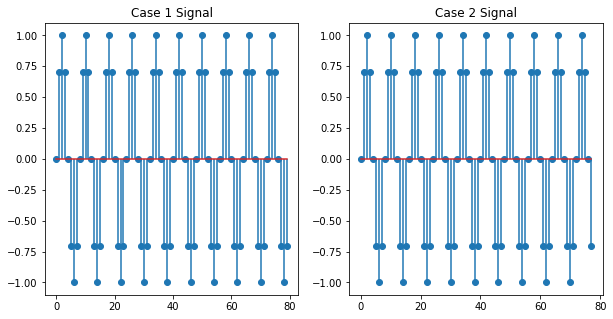

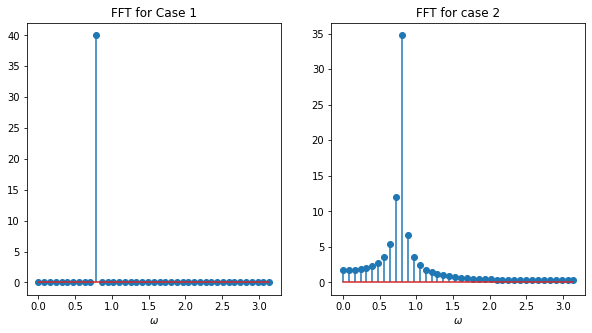

In [83]:
# Make longer signal that we will window in order to analyze a smaller portion
x = np.array([np.sin(np.pi/4*n) for n in range(200)])
# Case 1 
N1 = 80 # 10 full periods
x1 = x[:N1]
x1_fft = np.fft.rfft(x1)
omega_1 = np.linspace(0, np.pi, len(x1_fft))

# case 2
N2 = 78 # 7 full period and one fractional period
x2 = x[:N2]
x2_fft = np.fft.rfft(x2)
omega_2 = np.linspace(0, np.pi, len(x2_fft))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.stem(x1)
plt.title('Case 1 Signal')
plt.subplot(122)
plt.stem(x2)
plt.title('Case 2 Signal')

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.stem(omega_1, abs(x1_fft))
plt.title('FFT for Case 1')
plt.xlabel('$\omega$')
plt.subplot(122)
plt.stem(omega_2, abs(x2_fft))
plt.title('FFT for case 2')
plt.xlabel('$\omega$')

From the above example, we can see that although we are sampling the same sine wave signal, we obtain different frequency spectra for the two cases. The mismatch in sampling length for case 2 leads to the spectral leakage witnessed above. Recall that the mismatch in sampling size creates a discontinuity between the periodically extended copies of our finite window. This introduces other frequencies into the spectrum to compensate for this discontinuity. In practice, spectral leakage is unavoidable since many real-world signals have much richer frequency content. This is where windowing comes in.

We would like windowing to smooth out the discontinuity and decrease the impact of spectral leakage. There are many possible windows we may consider, but we will restrict ourselves to examining the following three:

1. Rectangular or Boxcar Window
2. Hamming Window
3. Kaiser ($\beta=3$)

a. Plot the time domain representation of each of these windows (using the ``N2=78`` from above). Hint: use $\textrm{scipy.signal.hamming()}$ and $\textrm{scipy.signal.kaiser()}$.

b. Plot the magnitude spectrum of each window on the same plot on a dB scale. **Please specify 512 points and use $\textrm{np.fft.rfft()}$**. You may use $\textrm{plt.plot()}$ instead of $\textrm{plt.stem()}$ since we have many points here. We have provided a function $\textrm{sig2db}$ that converts a magnitude response to dB scale. Comment on the differences in the magnitude spectrum of each window.

c. Apply each window to the sine wave signal we sampled with a fractional number of periods (``x2``) and plot the magnitude spectrum of each windowed result. Comment on the resulting spectra. How do the main lobe widths and side lobe heights of the sinusoid's peak differ?

C:\Users\matt3\AppData\Local\Temp\ipykernel_32396\1344547797.py:5: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(mag_spec)
C:\Users\matt3\AppData\Local\Temp\ipykernel_32396\1344547797.py:5: RuntimeWarning: invalid value encountered in multiply
  return 20*np.log10(mag_spec)
C:\Users\matt3\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\matt3\AppData\Local\Temp\ipykernel_32396\1344547797.py:5: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(mag_spec)
C:\Users\matt3\AppData\Local\Temp\ipykernel_32396\1344547797.py:5: RuntimeWarning: invalid value encountered in multiply
  return 20*np.log10(mag_spec)
C:\Users\matt3\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5, 1.0, 'Kaiser Output')

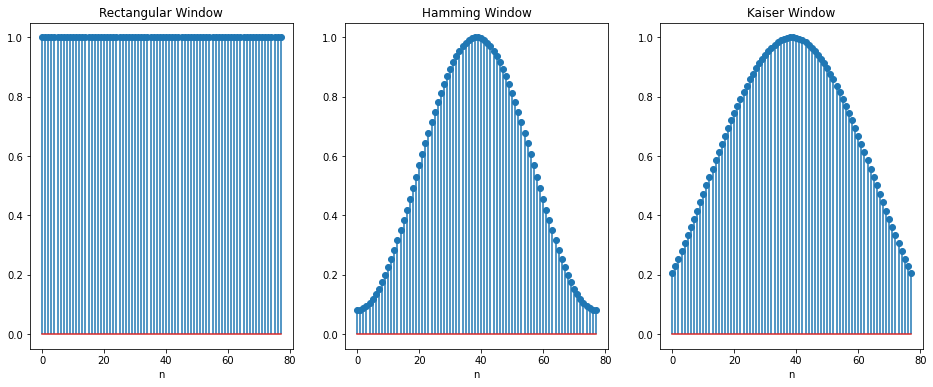

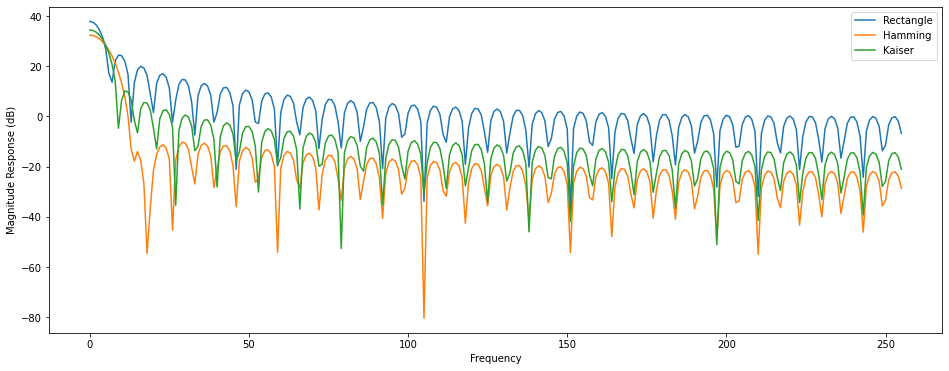

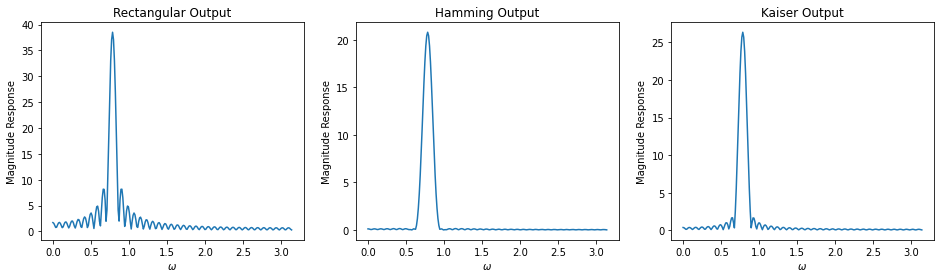

In [84]:
N2 = 78 # number of points we use to create our window
x2 = x[:N2]
# quick function for converting a magnitude response to dB
def sig2db(mag_spec):
    return 20*np.log10(mag_spec)


# Code for 2.a:
x = [i for i in range(N2)]
rect = np.array([1 for i in x2])
hamm = signal.windows.hamming(N2)
kai = signal.windows.kaiser(N2,3)

plt.figure(figsize=(16,6))
plt.subplot(131)
plt.stem(x, rect)
plt.title('Rectangular Window')
plt.xlabel("n")
plt.subplot(132)
plt.stem(x,hamm)
plt.title("Hamming Window")
plt.xlabel("n")
plt.subplot(133)
plt.stem(x,kai)
plt.title("Kaiser Window")
plt.xlabel("n")

# Code for 2.b:
fft_rect = np.fft.rfft(rect, 512)
fft_hamm = np.fft.rfft(hamm, 512)
fft_kai = np.fft.rfft(kai, 512)
omega = np.linspace(0, np.pi, len(fft_rect))

plt.figure(figsize=(16,6))
plt.plot(sig2db(fft_rect), label="Rectangle")
plt.plot(sig2db(fft_hamm), label="Hamming")
plt.plot(sig2db(fft_kai), label="Kaiser")
plt.xlabel("Frequency")
plt.ylabel("Magnitude Response (dB)")
plt.legend()

# Code for 2.c:
recty = np.fft.rfft(x2*rect, 512)
hammy = np.fft.rfft(x2*hamm, 512)
kaisery = np.fft.rfft(x2*kai, 512)
omega = np.linspace(0, np.pi, len(recty))

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(omega, np.abs(recty))
plt.xlabel("$\omega$")
plt.ylabel("Magnitude Response")
plt.title('Rectangular Output')
plt.subplot(132)
plt.plot(omega, np.abs(hammy))
plt.xlabel("$\omega$")
plt.ylabel("Magnitude Response")
plt.title("Hamming Output")
plt.subplot(133)
plt.plot(omega, np.abs(kaisery))
plt.xlabel("$\omega$")
plt.ylabel("Magnitude Response")
plt.title("Kaiser Output")

## Comments here

Part 2(b):
The rectangular window seems to have the highest lobes out of them and the hamming window seems to have the lowest lobes out of all of them. The kaiser window is inbetween.

Part 2(c):
The width is for the main and side lobes for the hamming output is the widest with the kaiser window being the next widest and the rectangular window being the narrowest. The heights of the main and side lobes have the rectangular window being the greatest followed by the kaiser window. The hamming window has the lowest lobe heights. This results in the hamming output being the smoothest out of the three windows and the rectangular output being the most rigid out of the three windows.

## Exercise 3: Zero-Padding00000

Now let's consider the problem of examining frequency content in a piece of music and how zero-padding affects our ability to do so. Load and listen to the below audio clip.

In [33]:
fs, music_stereo = wavfile.read('Hallelujah_16k.wav') # Import the sound file
music_mono = music_stereo[:,0] # To obtain mono sound track
Audio(music_mono, rate = fs)

C:\Users\matt3\AppData\Local\Temp\ipykernel_32396\133408743.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, music_stereo = wavfile.read('Hallelujah_16k.wav') # Import the sound file


There's a lot going on for such a short audio clip! What if we only look at the frequency content present in the first 256 samples?

Text(0, 0.5, 'Magnitude Response')

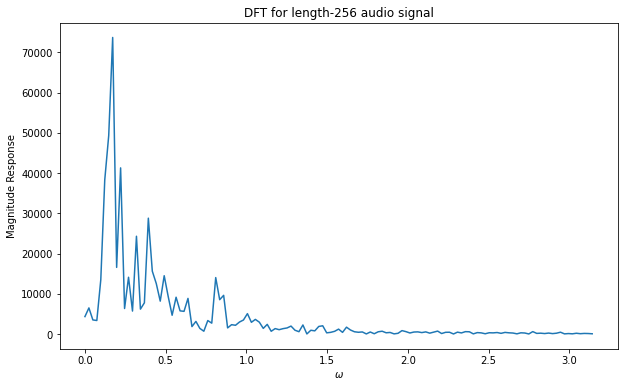

In [34]:
N = 256
music_mono_short = music_mono[:N] # if we are only given the first 256 samples
fft_short = np.fft.rfft(music_mono_short)
omega = np.linspace(0, np.pi, len(fft_short)) 
plt.figure(figsize =(10, 6))
plt.plot(omega, abs(fft_short))
plt.title('DFT for length-256 audio signal')
plt.xlabel(r'$\omega$')
plt.ylabel('Magnitude Response')

a. Zero-pad our length-256 clip to length 2048. Plot the new magnitude spectrum of our zero-padded signal.

b. Comment on the differences (quantitative or qualitative) that you observe. Has zero-padding improved our ability to distinguish different frequencies?

c. Now, if we are only given the first 16 samples instead of 256. Do you think zero-padding to length 2048 will also give us the ability to identify all the peaks like in the previous case? Why or why not?

Text(0.5, 1.0, 'DFT')

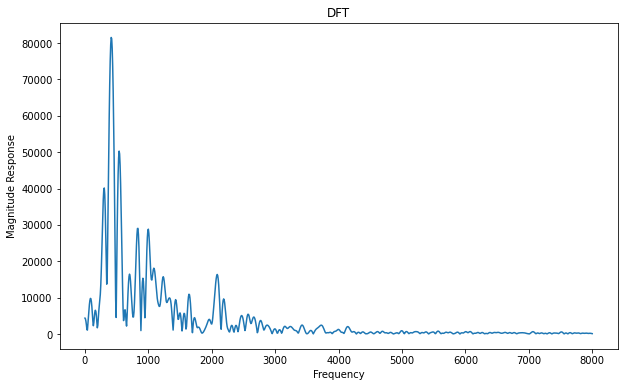

In [43]:
# Code for 3a:
zeropad = np.zeros(2048)
for i in range(N):
    zeropad[i] = music_mono_short[i]
fft_zeropad = np.fft.rfft(zeropad)
omega = [2*np.pi*k/2048*(fs/(2*np.pi)) for k in range(2048) if 2*np.pi*k/2048 <= np.pi] 
plt.figure(figsize =(10,6))
plt.plot(omega, abs(fft_zeropad))
plt.xlabel('Frequency')
plt.ylabel('Magnitude Response')
plt.title('DFT')

## Comments here

Part 3(b):
The graph has more rough edges and is more jaggy than the 256 sample DFT. The zero padding has improved our ability to distinguish frequencies because if it is more jaggy and less smooth, it means for frequencies are being detected. That is what causes the non-smooth look.

Part 3(c):
The graph would have more peaks than the original, but not as much as the second graph or previous case. This is because the data only samples 16 samples instead of 2048, limiting the amount of information we can get.

# Exercise 4: Spectrograms

Now let's look at the spectrogram for an audio signal. A spectrogram can be thought of as a two-dimensional signal with both time and frequency axes. Thus, the value of a spectrogram at a particular pair of time and frequency indicates how much energy we have of that frequency at the given time. Let visualize some examples to make this more concrete. Specifically, we have three audio files that contain three different speech sounds or utterances.

* Vowel "a": specifically, we hear the sound "ah"
* Consonant "r": speaker repeats the sound "rah"
* Constant "b": speaker repeats the sound "bah"

Let's listen to them and visualize their spectrograms! Note that all three clips contain the "ah" sound, so we should focus especially on the start of each sound. In other words, the beginning of each clip will contain the "ah", "ruh", and "buh" sounds that should distinguish each utterance.

In [36]:
fs_a, vowel_a = wavfile.read('a.wav') 
fs_r, cons_r = wavfile.read('r.wav') 
fs_b, cons_b = wavfile.read('b.wav') 

In [37]:
Audio(vowel_a, rate = fs_a)

In [38]:
Audio(cons_r, rate = fs_r)

In [39]:
Audio(cons_b, rate = fs_b)

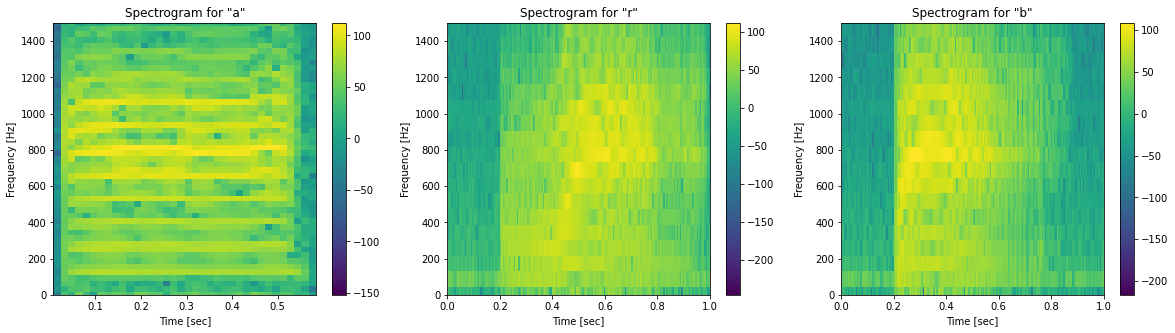

In [40]:
nfft = 512
f_a, t_a, S_a = signal.spectrogram(vowel_a, fs_a, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)
f_r, t_r, S_r = signal.spectrogram(cons_r, fs_r, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)
f_b, t_b, S_b = signal.spectrogram(cons_b, fs_b, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.pcolormesh(t_a, f_a, sig2db(S_a))
plt.title('Spectrogram for "a"')
plt.ylim([0, 1500])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(t_r, f_r, sig2db(S_r))
plt.title('Spectrogram for "r"')
plt.ylim([0, 1500])
plt.xlim([0, 1]) # limit the time axis to only see one iteration of the "rah" sound
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(t_b, f_b, sig2db(S_b))
plt.title('Spectrogram for "b"')
plt.ylim([0, 1500])
plt.xlim([0, 1]) # limit the time axis to only see one iteration of the "bah" sound
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()

a. Comment on the differences in the the above spectrograms. Which utterances have higher frequency content? Which have lower frequency content? Try thinking about the pitch of your voice when forming these sounds. Remember that the "r" and "b" clips both have the "ah" sound of the first clip, so some frequency content will be shared between all three clips

b. We have included a sound file ``robot.wav`` in the lab folder. This file contains a person saying the word "robot". Load the sound file and plot its spectrogram. Refer to the above spectrogram examples and the $\textrm{signal.spectrogram()}$ documentation if you are unsure how to do this.

c. We know that this word contains the two consonants "r" and "b". From the example spectrograms provided above, can you tell where these consonants appear in the word's spectrogram (i.e. what time do they start)? If so, where do the consonants "r" and "b" begin?

C:\Users\matt3\AppData\Local\Temp\ipykernel_32396\194504312.py:5: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(mag_spec)


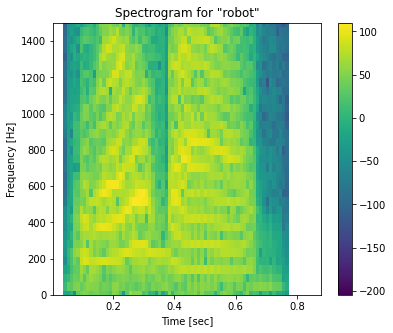

In [47]:
# Code for 4.b here:
fs_ro, ro = wavfile.read('robot.wav')
f_ro, t_ro, S_ro = signal.spectrogram(ro, fs_ro, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)

plt.figure(figsize=(6,5))
plt.pcolormesh(t_ro, f_ro, sig2db(S_ro))
plt.title('Spectrogram for "robot"')
plt.ylim([0, 1500])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()

## Comments here

Part 4(a):
"r" seems to have the highest frequecny content. "r" and "b" have frequencies at similar positions the only difference is that "r" seems to be more prevalent for a longer region of time, making it higher than "b". "ah" only has strips of frequencies and some areas really low, so the total frequency content of "ah" would be lower than "r" and "b".

Part 4(c):
Yes. From the shape, "r" seems to start a little before .1 seconds and "b" seems to start a little before .4 seconds.

# Circular Convolution and Related DFT Properties

A key assumption in the computation of the DFT is the periodic extension of the signal in the time domain. This periodicity also relates to the $2\pi$ periodicity of the DTFT and DFT.

$$
x[n] = x[n+N], \quad \forall k
$$

$$
X[k] = X[k+N], \quad \forall k
$$

Please refer to the ECE 310 textbook for further mathematical background. The important takeaway here is that any shifts in time must be circular. Consequently, the convolution that is induced in the time domain by multiplication in the DFT domain is circular. More concisely, multiplication in the DFT domain is circular convolution in the time domain. Thus, for a signal $x[n]$ and system $h[n]$ with DFTs $X[k]$ and $H[k]$, respectively, we have:

$$
X[k]H[k] \implies \sum_{n = 0}^{N-1}x[\langle m-n\rangle_N]h[m] = \sum_{n=0}^{N-1}x[m]h[\langle m-n\rangle_N],
$$

where $\langle k\rangle_N \equiv (k~\mod~N)$. Notice that circular convolution between two sequences produces a very different result from the ordinary linear convolution. Thus, we must be careful to make the circular convolution we perform equivalent to the linear convolution of the two sequences. This will guarantee that multiplying in the DFT domain will produce a result consistent with multiplication in the DTFT domain. How do we accomplish this? With zero-padding!

Recall that the linear convolution between length $L$ and length $M$ sequences lead to a length $L+M-1$ result. Conversely, the circular convolution of these sequences would be of length $\max\{L,M\}$; although, the two sequences are typically the same length already. Intuitively, if we want our circular convolution to be the same as our linear convolution, we should guarantee the result is of length $L+M-1$. And this will work! In order to make our circular convolution equivalent to the linear convolution result, we do the following:

$$
\textrm{length}(x) = L,\quad \textrm{length}(h) = M
$$

$$
x\implies \textrm{pad }M-1\textrm{ zeros}
$$
$$
h\implies \textrm{pad }L-1\textrm{ zeros}.
$$

This procedure will guarantee our convolution is the correct length and will also prevent aliasing due to the circular modulation of the shifting sequence. Now, why are we concerned with using the DFT and bothering with circular convolution? Consider that linearly convolving two sequences requires $\mathcal{O}(n^2)$ multiply-add operations. On the other hand, computing the DFT via the FFT takes $\mathcal{O}(n\log n)$ operations. Thus, if we take the DFT of both our signal and filter, multiply in the DFT domain, and perform the inverse DFT via the IFFT, we will have the following computational complexity:

$$
\underbrace{\mathcal{O}(n\log n) + \mathcal{O}(n\log n)}_{\textrm{DFT of signal/filter}} + \underbrace{\mathcal{O}(n)}_{X[k]H[k]} + \underbrace{\mathcal{O}(n\log n)}_{\textrm{Inverse DFT}} = \mathcal{O}(3n\log n) + \mathcal{O}(n) \implies \mathcal{O}(n\log n).
$$

These computational savings are especially impressive when $n$ becomes large for something like an audio signal. Thus, we can use the DFT to perform fast linear convolution for our LSI systems. Note that we assume zero-padding is a constant-time operation that does not meaningfully impact the computational complexity as a function of the signal length.

# Exercise 5: Fast Linear Convolution

In this exercise, you will create your own implementation of fast linear convolution via the DFT.  

a. Fill in the function $\textrm{fast_convolution()}$ to implement fast linear convolution via the DFT. Refer to the above background if you need help with the necessary steps. Verify the results of your function against $\textrm{signal.convolve()}$ with the provided sample input and filter by printing the output of your function and $\textrm{signal.convolve()}$. Hint: you may use $\textrm{np.fft.fft()}$ and $\textrm{np.fft.ifft()}$ to take the DFT and inverse DFT, respectively.

Next, we want to compare the running time of your fast linear convolution function against regular linear convolution via summation. Unfortunately, numpy and scipy's implementations of convolution via summation are too efficient (likely written in C code via Cython) to be compared against our fast convolution. As such, we have provided a function for you called $\textrm{linear_convolution(x1, x2)}$ that implements convolution by summation in Python. This will be a fairer test of the efficiency of your fast linear convolution function.

We have provided a testing framework that builds a random signal and filter of length $L$, calls your function and the linear convolution function, and outputs the running time.

b. Test the two functions for $L = 2^6=32$. Report the average running time in the below Markdown cell.

c. Test the two functions for $L = 2^{10}=1024$. Report the average running time.

d. Test the two functions for $L = 2^{14}=16384$. Report the average running time. (You may use $2^{12}$ or $2^{13}$ here if your laptop does not have enough memory for such large sequences.)

e. Comment on the results for each length. How do your results compare to the theoretical background given above?

In [51]:
# Code for 5.a:

# Fill in this function!
def fast_convolution(x, h):
    x1 = np.zeros(len(x) + len(h) - 1)
    h1 = np.zeros(len(x) + len(h) - 1)
    for i in range(len(x)):
        x1[i] = x[i]
    for i in range(len(x)):
        h1[i] = h[i]
    y = np.fft.ifft(np.fft.fft(x1)*np.fft.fft(h1))
    return y

# Test signals
x1 = [1, 3, -2, -1]
x2 = [0, 2, 4, 1]
print(fast_convolution(x1,x2))
print(signal.convolve(x1,x2))

[-1.26882631e-16+0.j  2.00000000e+00+0.j  1.00000000e+01+0.j
  9.00000000e+00+0.j -7.00000000e+00+0.j -6.00000000e+00+0.j
 -1.00000000e+00+0.j]
[ 0  2 10  9 -7 -6 -1]


In [55]:
# Testing framework for parts 5.b-5.d:
L = 2**13 # Change this for each part!
x = np.random.uniform(size=L)
h = np.random.uniform(size=L)
print('Regular Linear Convolution Results:')
%timeit linear_convolution(x, h)
print('Fast Linear Convolution Results:')
%timeit fast_convolution(x, h)

Regular Linear Convolution Results:
715 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Fast Linear Convolution Results:
16.8 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Comments and results here

Results for 5(b):

Regular Linear Convolution Results:<br>
77.6 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)<br>
Fast Linear Convolution Results:<br>
179 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

Results for 5(c):

Regular Linear Convolution Results:<br>
11.7 ms ± 954 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)<br>
Fast Linear Convolution Results:<br>
1.7 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Results for 5(d):

I had to use $2^{13}$ because I think my laptop doesn't have enough memory for $2^{14}$.

Regular Linear Convolution Results:<br>
715 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br>
Fast Linear Convolution Results:<br>
16.8 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Comments for 5(e):
As the length increases, the difference in how long each function takes significantly increases. In other words, the linear convolution time increases more as the length increases compared to the fast linear convolution. This makes sense theoretically because the time complexity of linear convolution is $O(n^2)$ and the time complexity of fast linear convolution is $O(nlogn)$.

# Exercise 6: Where's Waldo Going?

We will conclude this lab with an interesting (and cute) demonstration of DFT properties. The notion of the DFT is not limited to one-dimensional signals: we may go to arbitrary numbers of dimensions. For this exercise, we will work with the (two-dimensional) DFT of an image. We have provided the DFT of the test image.

a. For this part, we will apply a linear phase to each row of the image's DFT. Mathematically, this means you will multiply each row $r$ in the image's DFT by the following complex number

$$
\large{\textrm{Phase at row }r = e^{-j\frac{2\pi n_0}{R} r}},
$$

where $R$ is the number of rows in the image and $n_0$ is the phase offset we would like. Notice that each row is multiplied by its own constant complex number. This phase scales linearly from row-to-row. Apply linear phase along the rows of the test image for $n_0=100$. Take the inverse two-dimensional DFT of the resulting DFT and plot the real part of the resulting image. (Hint: use $\textrm{np.fft.ifft2()}$ and $\textrm{np.real()}$ here.) 

b. Apply linear phase to each column of the image's DFT for $n_0 = 100$. Take the inverse two-dimensional DFT of the resulting DFT and plot the real part of the resulting image. Note that you should divide by the number of columns in the above complex exponential for this case.

c. Apply linear phase to the rows and columns of the image's DFT. You may apply the phase along the rows then columns or columns then rows. Choose any non-zero offsets for the rows and columns, respectively.

d. Describe what is happening in the previous three parts. Why is this happening? Think about the DFT properties!

Text(0.5, 1.0, 'Linear Phase on Row and Column')

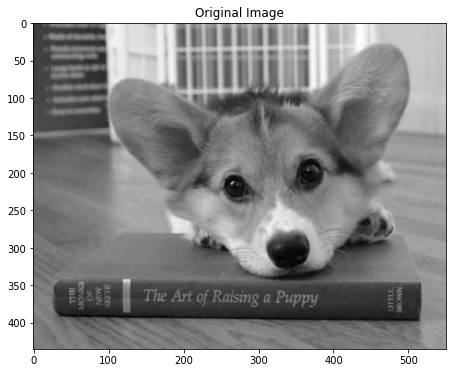

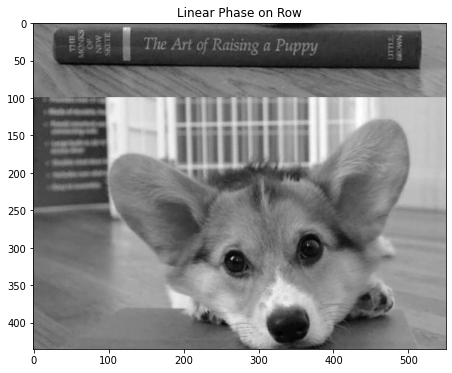

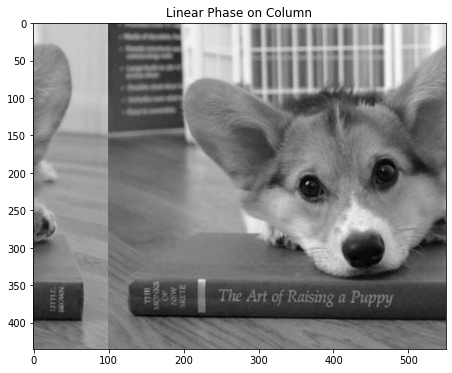

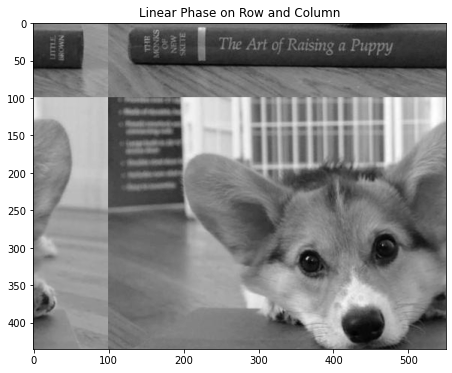

In [62]:
# Load and plot original image
img = imread('test-image.jpg')
n_rows = img.shape[0]
n_cols = img.shape[1]
plt.figure(figsize=(10, 6))
plt.imshow(img,'gray')
plt.title('Original Image')

# Compute 2D-DFT
fft2 = np.fft.fft2(img)

# Code for part 6.a:
part_a = fft2.copy() # create a hard copy to work with on part (a)
n = 100
for i in range(n_rows):
    phase = np.exp(-2j*np.pi*n*i/n_rows)
    part_a[i] = phase*fft2[i]
part_a = np.fft.ifft2(part_a)
part_a = np.real(part_a)
plt.figure(figsize=(10, 6))
plt.imshow(part_a, 'gray')
plt.title('Linear Phase on Row')

# Code for part 6.b:
part_b = fft2.copy()
for i in range(n_cols):
    phase = np.exp(-2j*np.pi*n0*i/n_cols)
    part_b[:,i] = phase*fft2[:,i]
part_b = np.fft.ifft2(part_b)
part_b = np.real(part_b)
plt.figure(figsize=(10, 6))
plt.imshow(part_b, 'gray')
plt.title('Linear Phase on Column')

# Code for part 6.c:
part_c = fft2.copy()
for i in range(n_rows):
    phase = np.exp(-2j*np.pi*n*i/n_rows)
    part_c[i] = phase*fft2[i]
for i in range(n_cols):
    phase = np.exp(-2j*np.pi*n*i/n_cols)
    part_c[:,i] = phase*part_c[:,i]
part_c = np.fft.ifft2(part_c)
part_c = np.real(part_c)
plt.figure(figsize=(10, 6))
plt.imshow(part_c,'gray')
plt.title('Linear Phase on Row and Column')

## Comments here

Part 6(d):
The images shift over either horozintally or vertically and the portions that go offscreen (or out of range) comes around from the other side. This happens because we are multiplying the image by a linear phase which does a circular shift on the image, resulting in the results described and seen above.

## Submission Instructions

Please rename this notebook to "netid_Lab5" and submit a zip file including all the supplied files for this lab to Canvas. Please also name your zip file submission "netid_Lab5".